# 7-3. **Transformer**
This code is from https://pytorch.org/tutorials/beginner/transformer_tutorial.html, pytorch official document about seq2seq modeling using Transformer.

In [1]:
!pip3 install -q torchtext==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00



**Sequence-to-Sequence Modeling with nn.Transformer and TorchText**

This is a tutorial on how to train a sequence-to-sequence model
that uses the
[nn.Transformer](https://pytorch.org/docs/master/nn.html?highlight=nn%20transformer#torch.nn.Transformer) module.

PyTorch 1.2 release includes a standard transformer module based on the
paper [Attention is All You
Need](https://arxiv.org/pdf/1706.03762.pdf) . The transformer model
has been proved to be superior in quality for many sequence-to-sequence
problems while being more parallelizable. The ``nn.Transformer`` module
relies entirely on an attention mechanism (another module recently
implemented as [nn.MultiheadAttention](https://pytorch.org/docs/master/nn.html?highlight=multiheadattention#torch.nn.MultiheadAttention) to draw global dependencies
between input and output. The ``nn.Transformer`` module is now highly
modularized such that a single component (like `nn.TransformerEncoder`
in this tutorial) can be easily adapted/composed.

![](https://github.com/pytorch/tutorials/blob/gh-pages/_static/img/transformer_architecture.jpg?raw=1)





Define the model
----------------




In this tutorial, we train ``nn.TransformerEncoder`` model on a
language modeling task. The language modeling task is to assign a
probability for the likelihood of a given word (or a sequence of words)
to follow a sequence of words.

A sequence of tokens are passed to the embedding
layer first, followed by a positional encoding layer to account for the order
of the word (see the next paragraph for more details). The
``nn.TransformerEncoder`` consists of multiple layers of
[nn.TransformerEncoderLayer](https://pytorch.org/docs/master/nn.html?highlight=transformerencoderlayer#torch.nn.TransformerEncoderLayer) . Along with the input sequence, a square
attention mask is required because the self-attention layers in
``nn.TransformerEncoder`` are only allowed to attend the earlier positions in
the sequence. For the language modeling task, any tokens on the future
positions should be masked. To have the actual words, the output
of ``nn.TransformerEncoder`` model is sent to the final Linear
layer, which is followed by a log-Softmax function.




### Transformer Model

In [2]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class TransformerModel(nn.Module):

    def __init__(self, ntoken, ninp, nhead, nhid, nlayers, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, ninp)
        self.ninp = ninp
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def _generate_square_subsequent_mask(self, sz):
        # triu returns the upper triangular part of a matrix (2-D tensor) or batch of matrices (see section below)
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output

#### Masking
By passing the mask into the transformer_encoder forward() function, the attention will only be calculated on the earlier positions in the sequence.

In [3]:
# triu returns the upper triangular part of a matrix (2-D tensor) or batch of matrices (see section below)
torch.triu(torch.ones(3, 3))

tensor([[1., 1., 1.],
        [0., 1., 1.],
        [0., 0., 1.]])

In [4]:
# Masking
def masking():
  sz = 4
  mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
  mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

  return mask

masking()

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

### Positional Encoding

Transformer architecture takes base architecture of Seq2Seq model (Encoder - Decoder). However, the transformer does not use recurrent model so this means we need a module that captures sequence information of the input/output.

``PositionalEncoding`` module injects some information about the
relative or absolute position of the tokens in the sequence. The
positional encodings have the same dimension as the embeddings so that
the two can be summed. Here, we use ``sine`` and ``cosine`` functions of
different frequencies.






In [5]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term) #0::2 means starting with index 0, step = 2
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

Load and batch data
-------------------




The training process uses Wikitext-2 dataset from ``torchtext``. The
vocab object is built based on the train dataset and is used to numericalize
tokens into tensors. Starting from sequential data, the ``batchify()``
function arranges the dataset into columns, trimming off any tokens remaining
after the data has been divided into batches of size ``batch_size``.
For instance, with the alphabet as the sequence (total length of 26)
and a batch size of 4, we would divide the alphabet into 4 sequences of
length 6:

\begin{align}\begin{bmatrix}
  \text{A} & \text{B} & \text{C} & \ldots & \text{X} & \text{Y} & \text{Z}
  \end{bmatrix}
  \Rightarrow
  \begin{bmatrix}
  \begin{bmatrix}\text{A} \\ \text{B} \\ \text{C} \\ \text{D} \\ \text{E} \\ \text{F}\end{bmatrix} &
  \begin{bmatrix}\text{G} \\ \text{H} \\ \text{I} \\ \text{J} \\ \text{K} \\ \text{L}\end{bmatrix} &
  \begin{bmatrix}\text{M} \\ \text{N} \\ \text{O} \\ \text{P} \\ \text{Q} \\ \text{R}\end{bmatrix} &
  \begin{bmatrix}\text{S} \\ \text{T} \\ \text{U} \\ \text{V} \\ \text{W} \\ \text{X}\end{bmatrix}
  \end{bmatrix}\end{align}

These columns are treated as independent by the model, which means that
the dependence of ``G`` and ``F`` can not be learned, but allows more
efficient batch processing.




In [6]:
import torchtext
from torchtext.data.utils import get_tokenizer
TEXT = torchtext.data.Field(tokenize=get_tokenizer('basic_english'),
                            init_token='<sos>',
                            eos_token='<eos>',
                            lower=True)
train_txt, val_txt, test_txt = torchtext.datasets.WikiText2.splits(TEXT)
TEXT.build_vocab(train_txt)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data, bsz):
    data = TEXT.numericalize([data.examples[0].text])
    # Divide the dataset into bsz parts.
    nbatch = data.size(0) // bsz
    # Trim off any extra elements that wouldn't cleanly fit (remainders).
    data = data.narrow(0, 0, nbatch * bsz)
    # Evenly divide the data across the bsz batches.
    data = data.view(bsz, -1).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_txt, batch_size)
val_data = batchify(val_txt, eval_batch_size)
test_data = batchify(test_txt, eval_batch_size)

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:01<00:00, 2.54MB/s]


extracting


In [7]:
print(train_data.shape)
print(val_data.shape)

torch.Size([104335, 20])
torch.Size([21817, 10])


Functions to generate input and target sequence



``get_batch()`` function generates the input and target sequence for
the transformer model. It subdivides the source data into chunks of
length ``bptt``. For the language modeling task, the model needs the
following words as ``Target``. For example, with a ``bptt`` value of 2,
we’d get the following two Variables for ``i`` = 0:

![](https://github.com/pytorch/tutorials/blob/gh-pages/_static/img/transformer_input_target.png?raw=1)


It should be noted that the chunks are along dimension 0, consistent
with the ``S`` dimension in the Transformer model. The batch dimension
``N`` is along dimension 1.




In [8]:
bptt = 35
def get_batch(source, i):
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].view(-1)
    return data, target

In [9]:
print(get_batch(train_data, 0)[0].shape)

torch.Size([35, 20])


Initiate an instance
--------------------




The model is set up with the hyperparameter below. The vocab size is
equal to the length of the vocab object.




In [10]:
ntokens = len(TEXT.vocab.stoi) # the size of vocabulary
emsize = 200 # embedding dimension
nhid = 200 # the dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2 # the number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2 # the number of heads in the multiheadattention models
dropout = 0.2 # the dropout value
model = TransformerModel(ntokens, emsize, nhead, nhid, nlayers, dropout).to(device)

In [11]:
len(TEXT.vocab.stoi)

28785

Run the model
-------------




`CrossEntropyLoss `
is applied to track the loss and
`SGD `
implements stochastic gradient descent method as the optimizer. The initial
learning rate is set to 5.0. `StepLR ` is
applied to adjust the learn rate through epochs. During the
training, we use
`nn.utils.clip_grad_norm_ `
function to scale all the gradient together to prevent exploding.




In [12]:
criterion = nn.CrossEntropyLoss()
lr = 5.0 # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

import time
def train(model, epoch, log_interval = 200):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output.view(-1, ntokens), targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.2f} | ms/batch {:5.2f} | '
                  'loss {:5.2f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // bptt, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()


def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, bptt):
            data, targets = get_batch(data_source, i)
            output = eval_model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += len(data) * criterion(output_flat, targets).item()
    return total_loss / (len(data_source) - 1)

Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [13]:
best_val_loss = float('inf')
epochs = 3 # The number of epochs
best_model = None

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model, epoch)
    val_loss = evaluate(model, val_data)
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
          'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

    scheduler.step()

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |   200/ 2981 batches | lr 5.00 | ms/batch 32.66 | loss  8.01 | ppl  3019.73
| epoch   1 |   400/ 2981 batches | lr 5.00 | ms/batch 15.39 | loss  6.77 | ppl   872.17
| epoch   1 |   600/ 2981 batches | lr 5.00 | ms/batch 21.96 | loss  6.35 | ppl   571.55
| epoch   1 |   800/ 2981 batches | lr 5.00 | ms/batch 20.18 | loss  6.23 | ppl   505.82
| epoch   1 |  1000/ 2981 batches | lr 5.00 | ms/batch 15.70 | loss  6.11 | ppl   448.73
| epoch   1 |  1200/ 2981 batches | lr 5.00 | ms/batch 15.83 | loss  6.08 | ppl   439.21
| epoch   1 |  1400/ 2981 batches | lr 5.00 | ms/batch 15.39 | loss  6.04 | ppl   419.30
| epoch   1 |  1600/ 2981 batches | lr 5.00 | ms/batch 15.32 | loss  6.04 | ppl   419.59
| epoch   1 |  1800/ 2981 batches | lr 5.00 | ms/batch 15.52 | loss  5.96 | ppl   386.14
| epoch   1 |  2000/ 2981 batches | lr 5.00 | ms/batch 16.22 | loss  5.95 | ppl   383.92
| epoch   1 |  2200/ 2981 batches | lr 5.00 | ms/batch 15.61 | loss  5.84 | ppl   344.31
| epoch   1 |  2400/ 

Evaluate the model with the test dataset
-------------------------------------

Apply the best model to check the result with the test dataset.



In [14]:
test_loss = evaluate(best_model, test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
    test_loss, math.exp(test_loss)))
print('=' * 89)

| End of training | test loss  5.43 | test ppl   227.95


# Exercise
Try different number of heads in Multi-head Attention, or different number of encoders, and record the test performance. Draw a graph to show the test performance (validation losses/ppls) vs number of heads, or the test performance (validation losses/ppls) vs number of encoders, (you can keep epochs = 3)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
test_losses = []
val_epoch_losses = []
nlayers_range = # Please complete this

for nlayers in nlayers_range:
    print('-' * 89)
    print('{} encoders'.format(nlayers))
    print('-' * 89)
    # define a model, an optimizer, a scheduler
    # Please complete this

    # train the model
    val_losses = []
    # Please complete this

    val_epoch_losses.append(val_losses)
    test_loss = evaluate(best_model, test_data)
    test_losses.append(test_loss)
    print('-' * 89)
    print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
        test_loss, math.exp(test_loss)))
    print('-' * 89)

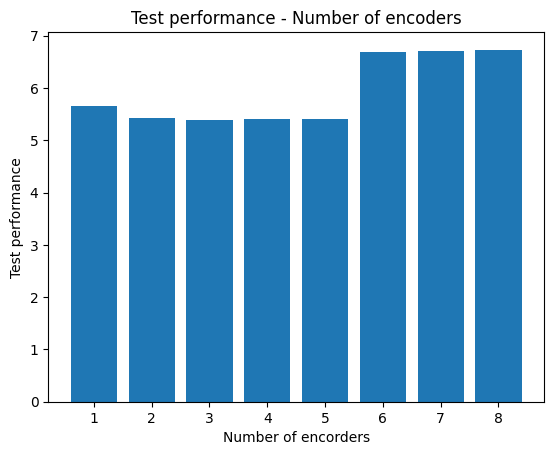

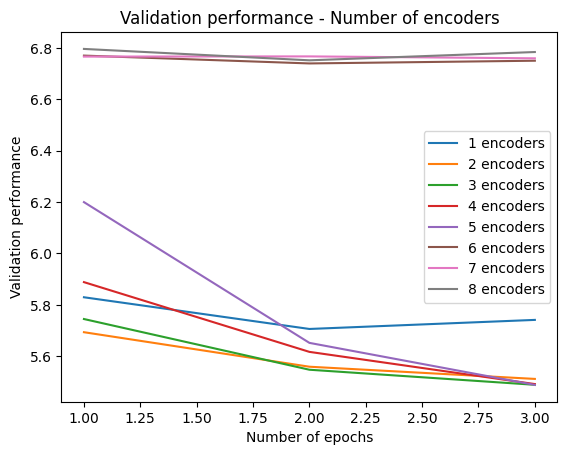

In [16]:
plt.bar(nlayers_range, test_losses)
plt.title('Test performance - Number of encoders')
plt.xlabel('Number of encorders')
plt.ylabel('Test performance')
plt.show()

for val_losses in val_epoch_losses:
    plt.plot(range(1, epochs+1), val_losses)
legend = ['{} encoders'.format(i) for i in nlayers_range]
plt.title('Validation performance - Number of encoders')
plt.legend(legend)
plt.xlabel('Number of epochs')
plt.ylabel('Validation performance')
plt.show()